# Random forest exploration using graph partition feature

In [43]:
%env PYTHONHASHSEED=0

from IPython.lib.deepreload import reload

%load_ext autoreload
%autoreload 2


env: PYTHONHASHSEED=0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx

from tv_show_recommender.pipelines import get_basic_nn_pipeline, get_cluster_labeled_nn_pipeline


np.random.seed(42)



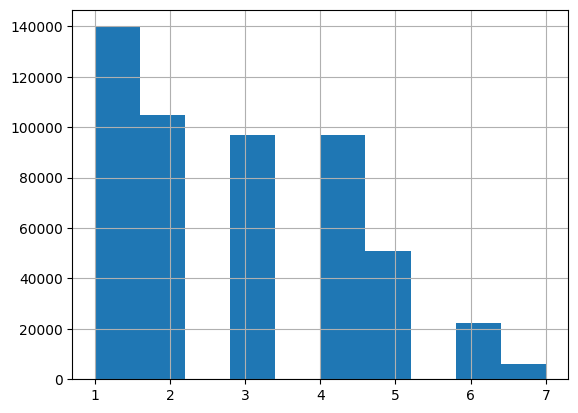

In [45]:
from tv_show_recommender.data.functions import get_stratified_data

train_set, test_set = get_stratified_data()

In [46]:
pipeline = get_basic_nn_pipeline()
data_prepared = pipeline.fit_transform(train_set)

data_processed = data_prepared.drop_duplicates(subset=['user_id', 'show_id'])
show_user_df = data_processed.pivot(index='user_id', columns='show_id', values='is_liked').fillna(0)

show_user_df.head()


show_id  43208     47708     50051     52520     53479     53488     53502     \
user_id                                                                         
11            0.0       0.0       0.0       0.0       0.0       0.0       0.0   
39            0.0       0.0       0.0       0.0       0.0       0.0       0.0   
436           0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1414          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2043          0.0       0.0       0.0       0.0       0.0       0.0       0.0   

show_id  54533     55683     56751     ...  22014226  22074164  22185582  \
user_id                                ...                                 
11            0.0       0.0       0.0  ...       0.0       0.0       0.0   
39            0.0       0.0       0.0  ...       0.0       0.0       0.0   
436           0.0       0.0       0.0  ...       0.0       0.0       0.0   
1414          0.0       0.0       0.0  ...       0.0       0.0       0.0   
2043          0.0       0.0       0.0  ...       0.0       0.0       0.0   

show_id  22297578  22373148  23037654  23900194  26693803  28227737  28857177  
user_id                                                                        
11            0.0       0.0       0.0       0.0       0.0       0.0       0.0  
39            0.0       0.0       0.0       0.0       0.0       0.0       0.0  
436           0.0       0.0       0.0       0.0       0.0       0.0       0.0  
1414          0.0       0.0       0.0       0.0       0.0       0.0       0.0  
2043          0.0       0.0       0.0       0.0       0.0       0.0       0.0  

[5 rows x 1722 columns]

In [47]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(show_user_df.T)

similarities = knn.kneighbors(show_user_df.T, return_distance=False)


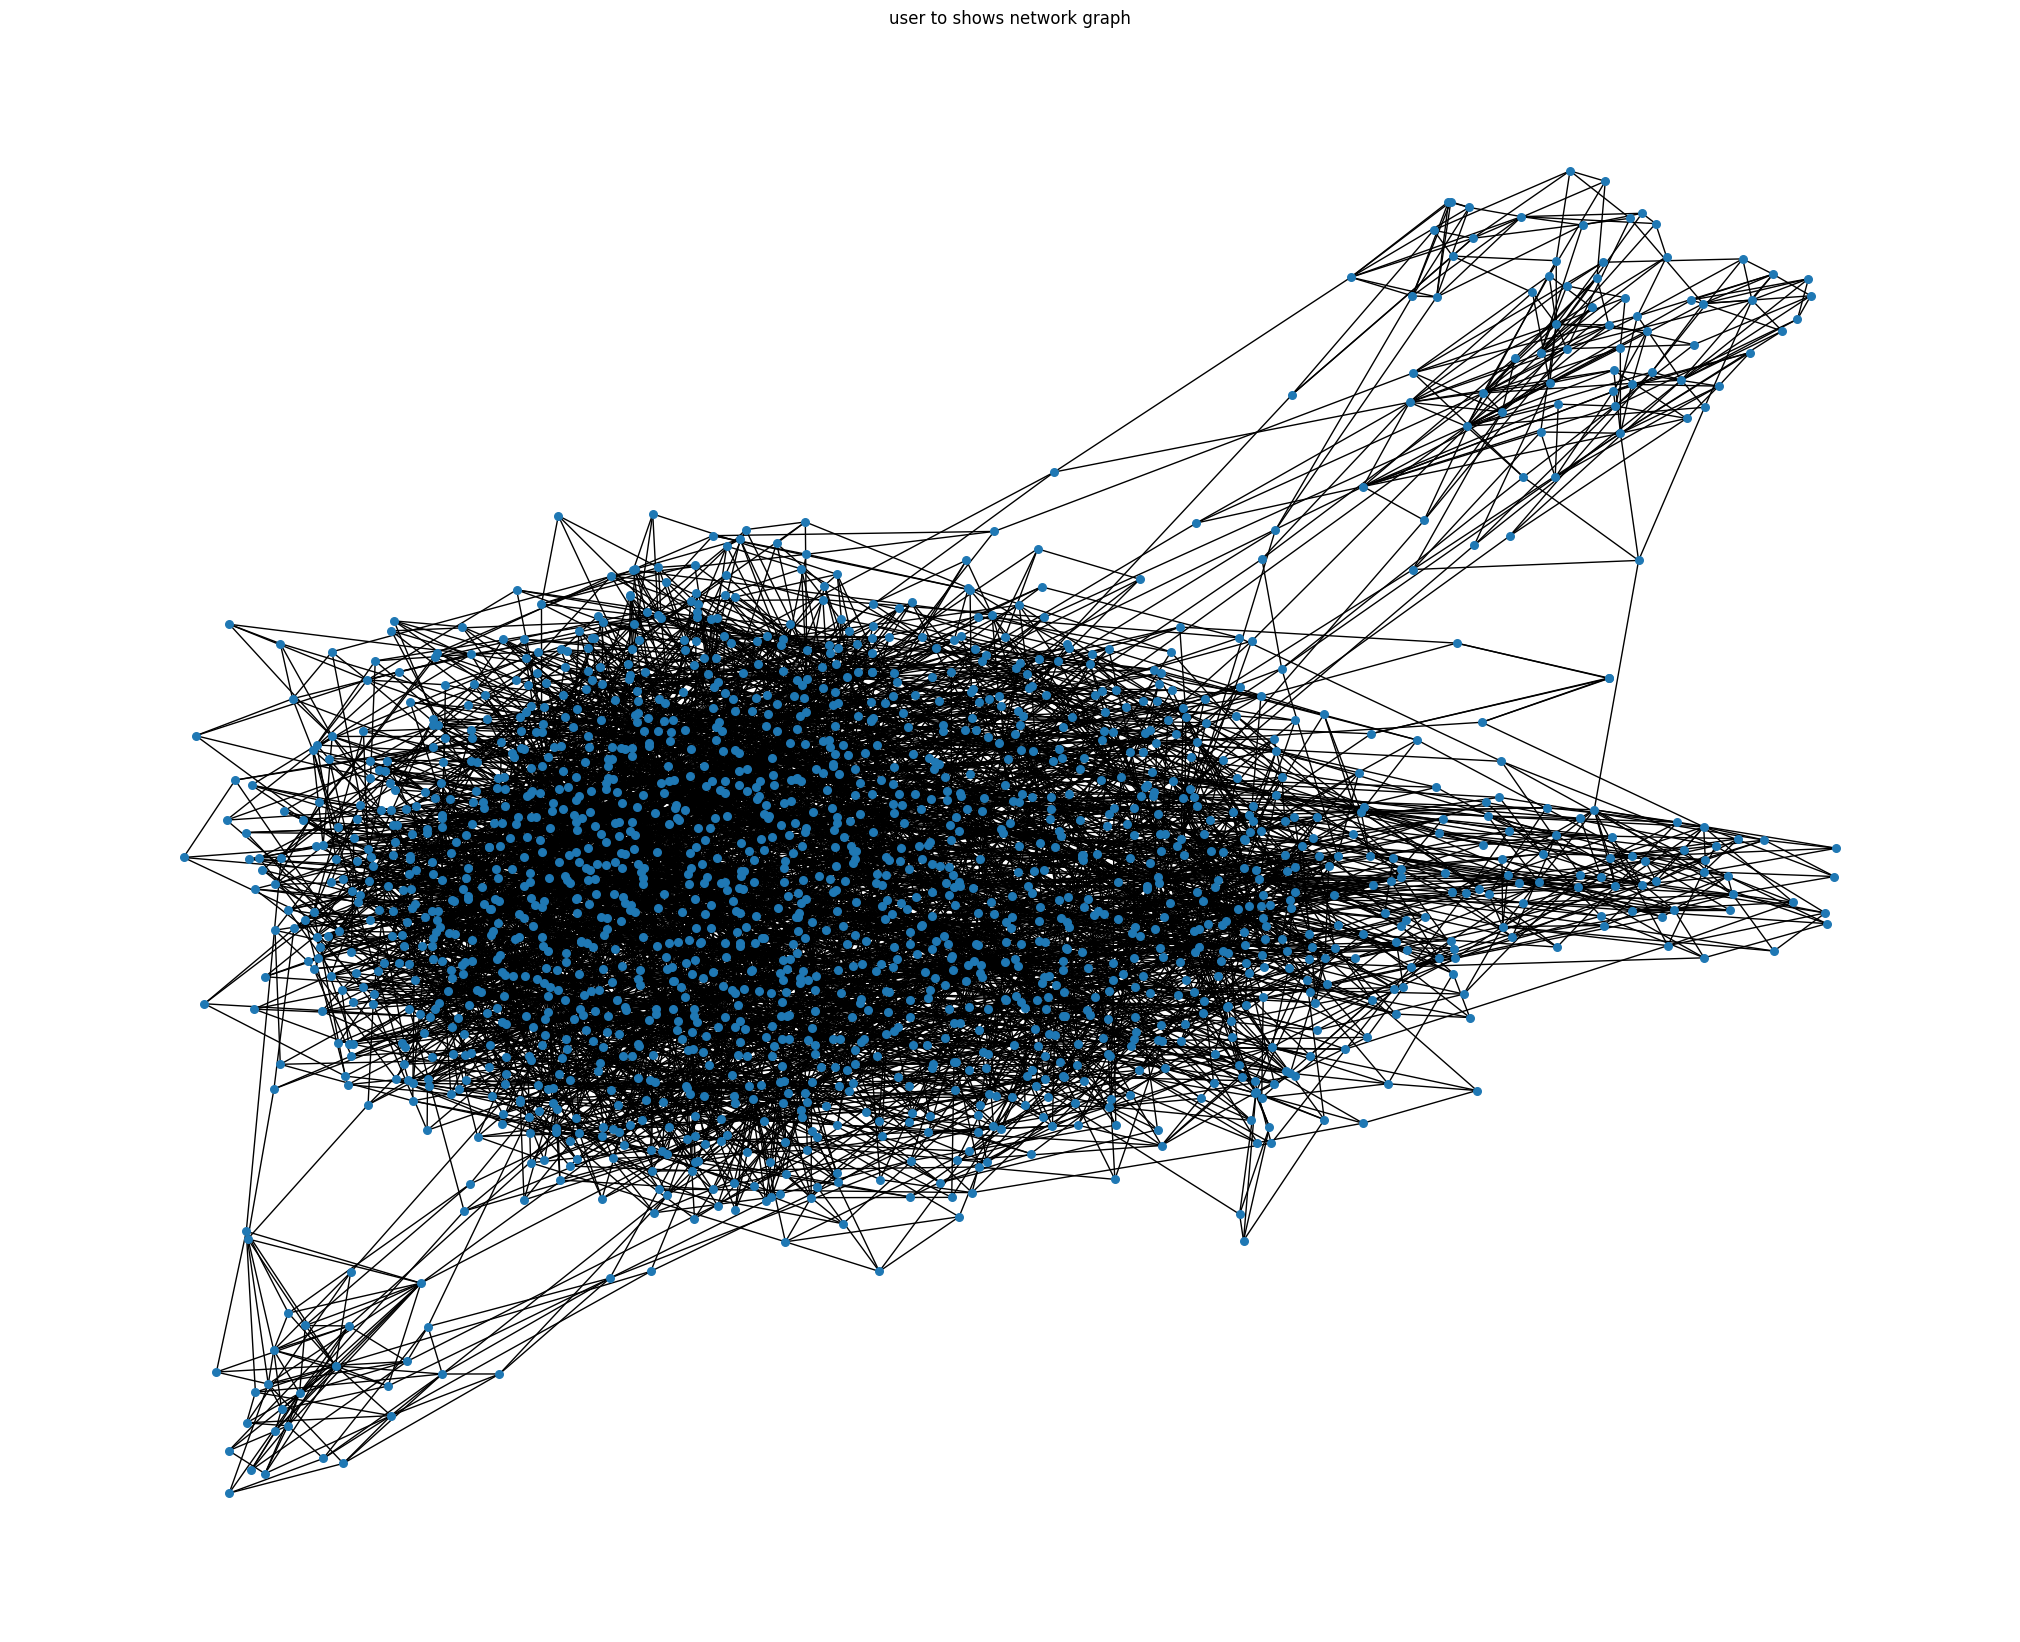

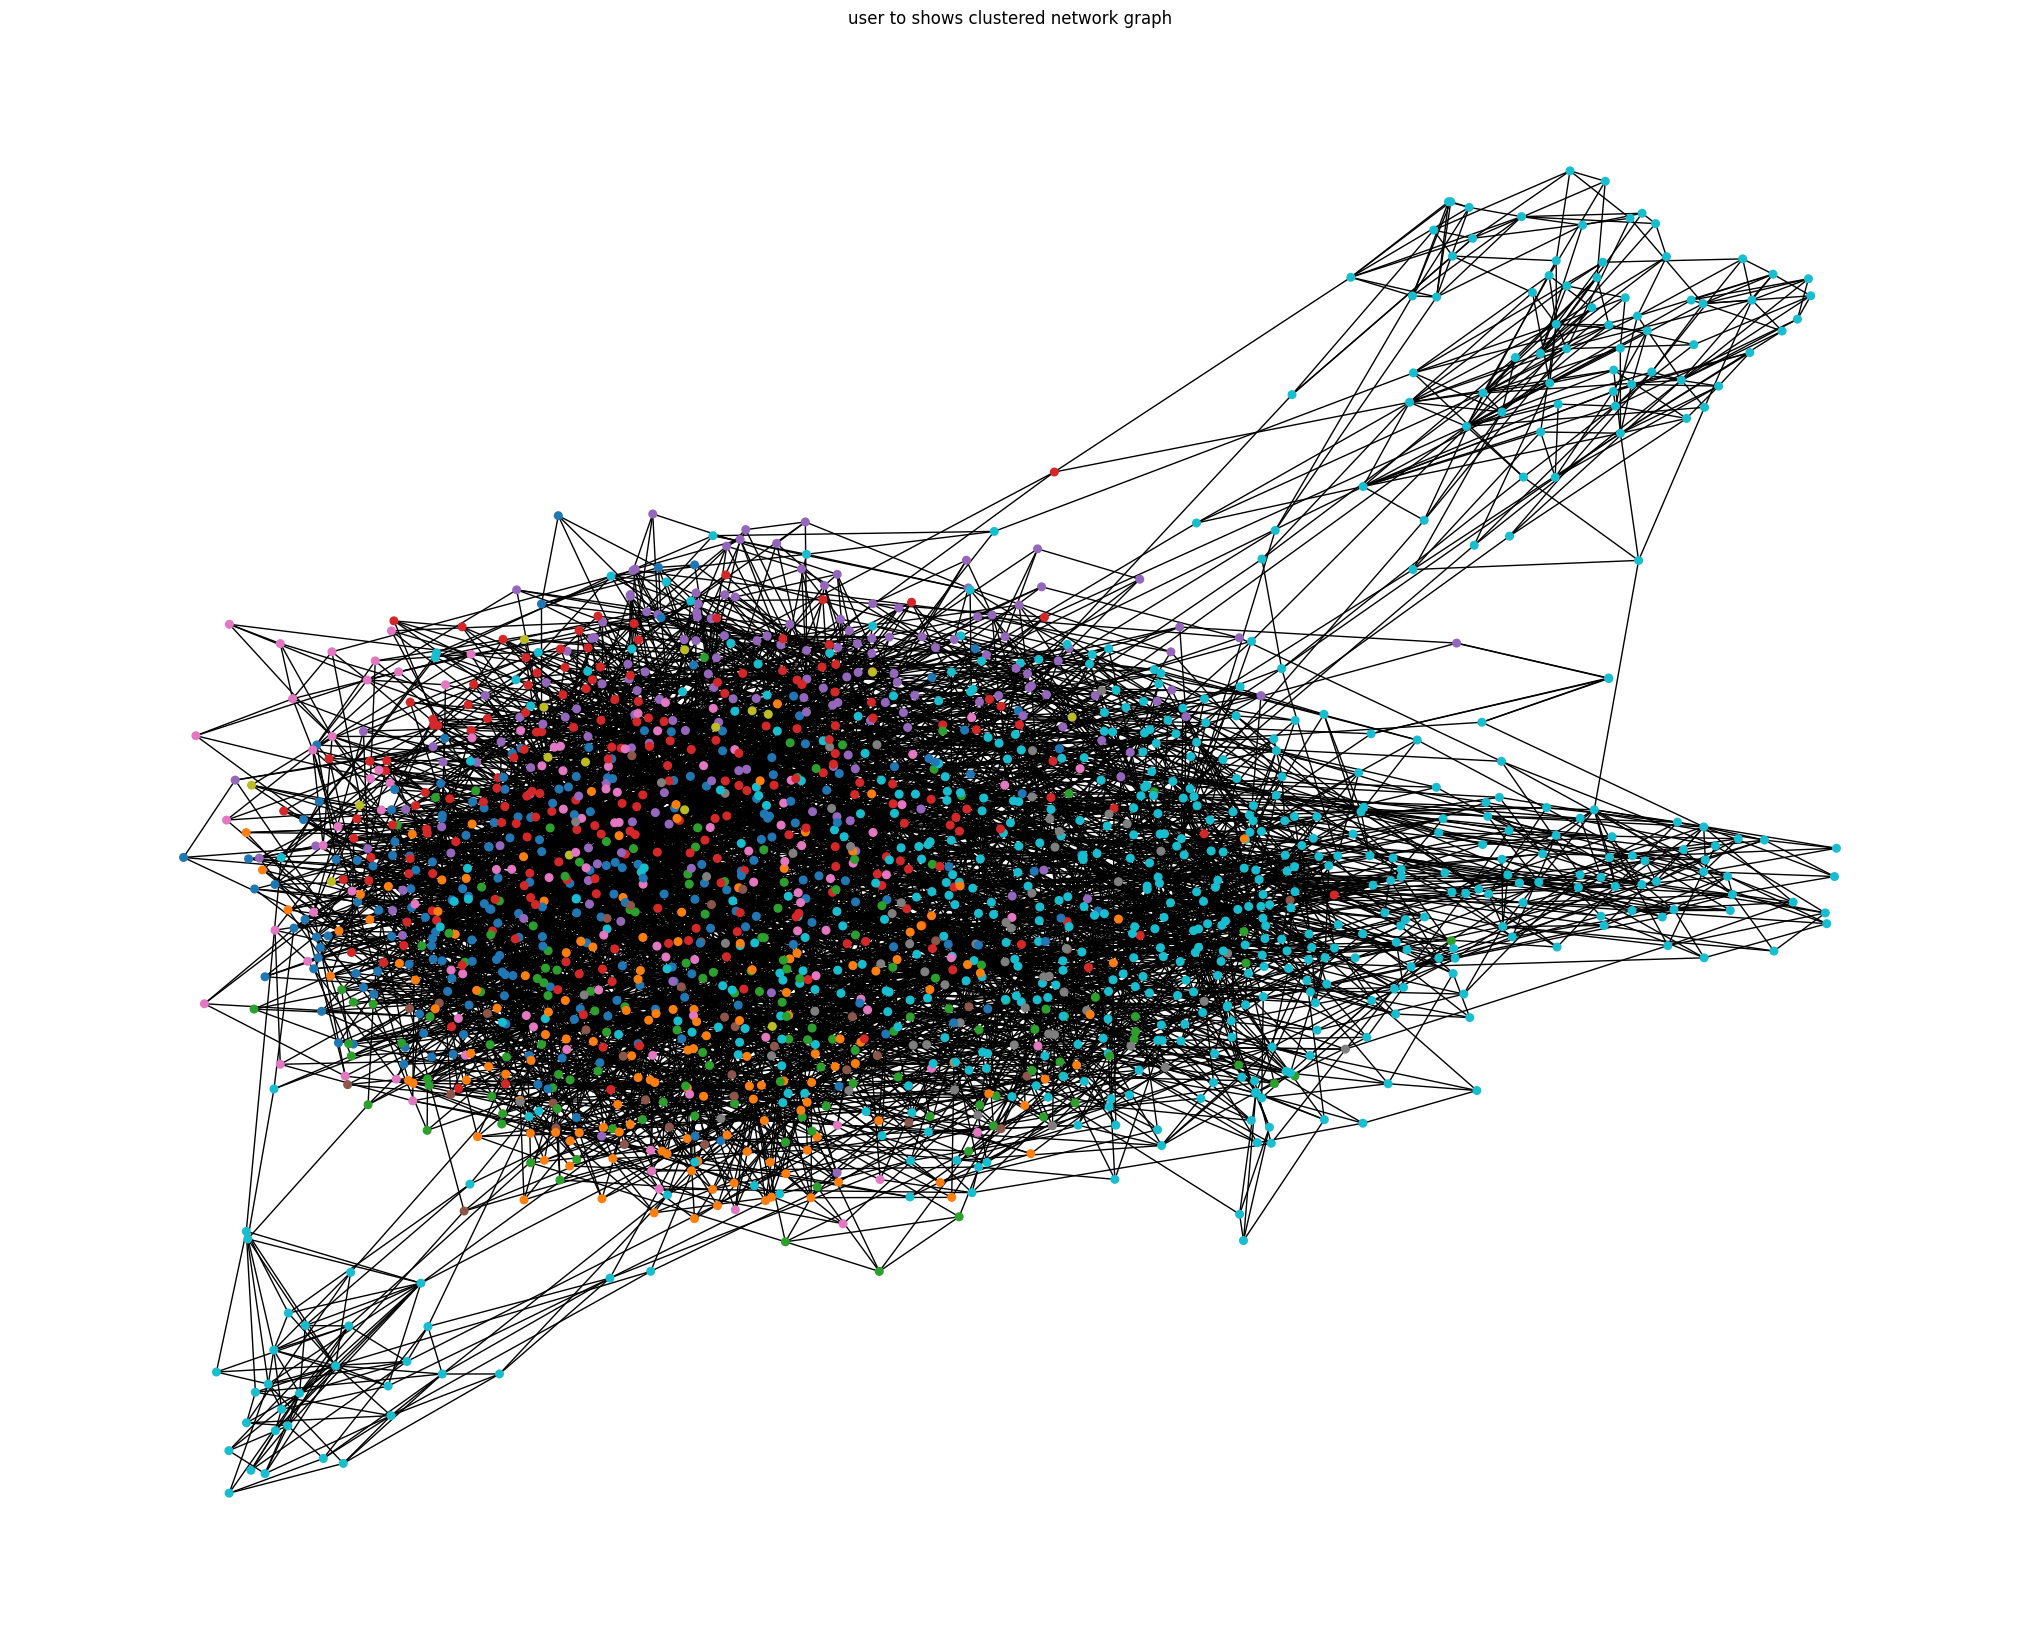

In [48]:
# What about a network graph?

G = nx.Graph()

# Add nodes to the graph
for i in range(len(show_user_df.T)):
    G.add_node(i)  # Each node represents an item/user

# Add edges based on similarities
for i, neighbors in enumerate(similarities):
    for neighbor in neighbors[1:]:  # Skip the first neighbor as it's itself
        G.add_edge(i, neighbor, weight=1)  # You can use similarity scores as edge weights

# Visualize the network graph
plt.figure(figsize=(20, 16))
pos = nx.spring_layout(G)  # Layout algorithm to position nodes
nx.draw(G, pos, with_labels=False, node_size=30)
plt.title('user to shows network graph')
plt.show()
# How about a clustered network graph?

import community
import matplotlib.cm as cm

# Compute the best partition using the Louvain algorithm
partition = community.best_partition(G)

# Assign cluster information to nodes
for node, cluster_id in partition.items():
    G.nodes[node]['cluster'] = cluster_id
    G.nodes[node]['show_index'] = node

# Visualize the clustered network graph
plt.figure(figsize=(20, 16))
pos = nx.spring_layout(G, seed=42)

# Assign colors to nodes based on their clusters
node_colors = [cm.tab10(partition[node]) for node in G.nodes()]
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=30)
plt.title('user to shows clustered network graph')
plt.show()


In [49]:
# So, there are an obvious number of distinct clusters:
# red, blue, green, orange, pink, lightgreen, brown, darkblue, ..., from observation
# Let's try to retrieve the number of partitions (and some sample data from each for fun)
# Maybe we can use the # of partitions in a KMeans model test

def retrieve_data_by_partition(graph, partition_dict):
    data_by_partition = {}
    for node, partition_id in partition_dict.items():
        if partition_id not in data_by_partition:
            data_by_partition[partition_id] = []
        # Assuming 'data' is the attribute containing the data you want to retrieve
        if 'show_index' in graph.nodes[node]:
            data_by_partition[partition_id].append(graph.nodes[node]['show_index'])
    return data_by_partition


def get_show_ids_from_indexes(show_indexes=[]):
    ids = []
    for index in show_indexes:
        id = show_user_df.columns[index]
        ids.append(id)
    return ids


data_by_partition = retrieve_data_by_partition(G, partition)

for partition_id, data_samples in data_by_partition.items():
    print(f"Partition {partition_id}: {len(data_samples)} samples")
    print("First few samples:")
    print(get_show_ids_from_indexes(data_samples[:5]))
    print("---------")

# 15 partitions
# From investigating the data, a lot of these shows seem grouped by start_date
# They also seem grouped by genre (e.g. sci-fi nerds like other sci-fi shows)
# Let's try using this network graph to find similar shows

Partition 0: 216 samples
First few samples:
[43208, 50051, 52520, 53479, 53502]
---------
Partition 1: 148 samples
First few samples:
[47708, 73972, 88527, 105950, 106052]
---------
Partition 2: 149 samples
First few samples:
[53488, 55683, 57733, 63929, 71007]
---------
Partition 3: 217 samples
First few samples:
[56751, 63939, 72500, 81912, 83505]
---------
Partition 4: 171 samples
First few samples:
[57773, 75596, 84967, 85033, 86827]
---------
Partition 5: 37 samples
First few samples:
[60028, 92455, 105946, 106145, 112178]
---------
Partition 6: 108 samples
First few samples:
[86662, 98763, 98948, 103442, 103491]
---------
Partition 11: 77 samples
First few samples:
[98830, 115083, 115147, 238784, 284718]
---------
Partition 8: 16 samples
First few samples:
[98904, 108778, 367279, 369179, 386676]
---------
Partition 9: 155 samples
First few samples:
[106080, 141842, 264235, 306414, 348914]
---------
Partition 10: 96 samples
First few samples:
[112159, 118266, 139774, 182629, 18513

In [50]:
from collections import defaultdict

def find_similar_shows(liked_shows, G):
    similar_shows = set()
    for show_id in liked_shows:
        show_idx = show_user_df.columns.get_loc(show_id)
        # Get neighbors (connected shows) for each show in the list of liked shows
        similar_shows.update(nx.all_neighbors(G, show_idx))
    # Exclude already liked shows and return the set of similar shows
    return list(similar_shows - set(liked_shows))


def find_similar_shows_aggregate(liked_shows, G):
    neighbors_count = defaultdict(int)
    for show_id in liked_shows:
        show_idx = show_user_df.columns.get_loc(show_id)
        for neighbor in G.neighbors(show_idx):
            neighbors_count[neighbor] += 1

    # Sort shows based on aggregate neighbor count in descending order
    similar_shows_sorted = sorted(neighbors_count, key=neighbors_count.get, reverse=True)

    # Exclude already liked shows and return the sorted list of similar shows
    return [show for show in similar_shows_sorted if show not in liked_shows]


def rank_recommendations(similar_recommendations, G):
    ranked_recommendations = sorted(similar_recommendations, key=lambda x: G.degree(x), reverse=True)
    return ranked_recommendations


# The Wire, DS9, The Sopranos
liked_shows = [306414, 106145, 141842]

similar_recommendations_idx = find_similar_shows_aggregate(liked_shows, G)
similar_recommendations = get_show_ids_from_indexes(similar_recommendations_idx)

print("Similar shows recommended based on user's likes:")
print(similar_recommendations)


Similar shows recommended based on user's likes:
[903747, 979432, 141842, 98830, 60028, 92455, 105946, 112178, 244365, 118421, 118480, 306414, 96548]


1. Prepare the Feature Set:
Create Features: Include the show's partitions along with other relevant features (if available) for the shows in the user-show interaction matrix or feature set.

2. Train the Random Forest Model:
Fit the Model: Train the Random Forest model using the prepared feature set and the target variable (e.g., user's preferences).

3. Generate Recommendations:
Input Liked Show IDs: When a user provides a list of show IDs they already like, extract the features for those shows from the feature set.
Predict with the Model: Use the trained model to predict the target variable (e.g., user's preferences) for the provided liked show IDs.
Rank Recommendations: Rank the shows based on the predicted scores and exclude the ones the user already likes.

```
# Assuming 'df' is your user-show DataFrame
# Assuming 'partition' is the partition dictionary obtained from Louvain algorithm
# Assuming 'model' is the trained Random Forest model

# Function to get recommendations for a user based on liked show IDs
def get_recommendations(liked_shows, df, partition, model):
    # Extract features for liked shows
    liked_show_features = df.loc[liked_shows]
    liked_show_features['partition_id'] = [partition[show_id] for show_id in liked_show_features.index]

    # Predict with the model
    predicted_scores = model.predict_proba(liked_show_features.drop(columns='target_column'))[:, 1]
    liked_show_features['predicted_score'] = predicted_scores

    # Rank recommendations based on predicted scores and exclude liked shows
    recommendations = liked_show_features.sort_values('predicted_score', ascending=False)
    recommendations = recommendations[~recommendations.index.isin(liked_shows)]

    return recommendations.index.tolist()  # Return recommended show IDs

# Example: Get recommendations for a user based on liked show IDs
liked_shows = ['show_1', 'show_2']  # Replace with the list of liked show IDs
recommendations = get_recommendations(liked_shows, df, partition, model)
print("Recommended shows for the user:")
print(recommendations)

# Let's do some feature engineering to try a new approach

In [51]:
from tv_show_recommender.data.functions import get_all_data

# Let's try using a show's graph partition to generate more features

# TODO: add pipeline step to accommodate graph feature-ization (e.g. which partition is it a part of)
# Maybe add start date too?
# Maybe add avg rating too?
# Then try random forest...?

data = get_all_data()
pipeline = get_cluster_labeled_nn_pipeline()
data = pipeline.fit_transform(data)

data.head()


show_id   user_id  start_year  average_rating  is_liked  partition_id
0  2402207   2860723        2014             7.4         0          10.0
1  2402207  22484170        2014             7.4         1          10.0
2  2402207     11762        2014             7.4         0          10.0
3  2402207  44112735        2014             7.4         0          10.0
4  2402207  18044142        2014             7.4         0          10.0

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Let's try training a Random Forest model

# Features
X = data[['start_year', 'average_rating', 'partition_id']]

# Target variable
y = data['is_liked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [53]:
def get_recommendations(liked_shows, model, data):
    # Set 'show_id' as index to retain it in the sliced DataFrame
    data_indexed = data.set_index('show_id')

    # Get all show IDs except for the liked shows
    all_show_ids = data_indexed.index.unique()
    non_liked_shows = [show_id for show_id in all_show_ids if show_id not in liked_shows]

    # Extract features for all shows excluding the liked shows
    non_liked_features = data_indexed.loc[non_liked_shows, ['start_year', 'average_rating', 'partition_id']]

    # Predict with the model for non-liked shows
    predicted_scores = model.predict_proba(non_liked_features)[:, 1]

    # Create a DataFrame with predictions for non-liked shows
    recommendations = pd.DataFrame({'predicted_score': predicted_scores}, index=non_liked_features.index)

    # Rank recommendations based on predicted scores
    ranked_recommendations = recommendations.sort_values('predicted_score', ascending=False)

    # Exclude the provided liked shows from recommendations
    final_recommendations = ranked_recommendations[~ranked_recommendations.index.isin(liked_shows)]

    final_recommendations = final_recommendations[~final_recommendations.index.duplicated()]

    return final_recommendations.index.tolist()[:5]  # Return recommended show IDs

# The Wire, DS9, The Sopranos
liked_shows = [306414, 106145, 141842]
recommendations = get_recommendations(liked_shows, model, data)

print("Recommended shows for the user:")
print(recommendations)

Recommended shows for the user:
[108847, 1298820, 3671754, 90509, 2311418]
